In [1]:
import numpy as np
import scipy.stats
import astropy
import pylab as plt

In [2]:

from astroML.datasets import fetch_dr7_quasar

# Fetch the quasar data
quasars = fetch_dr7_quasar()

# select the first 10000 points
quasars = quasars[:10000]

data = quasars['redshift']

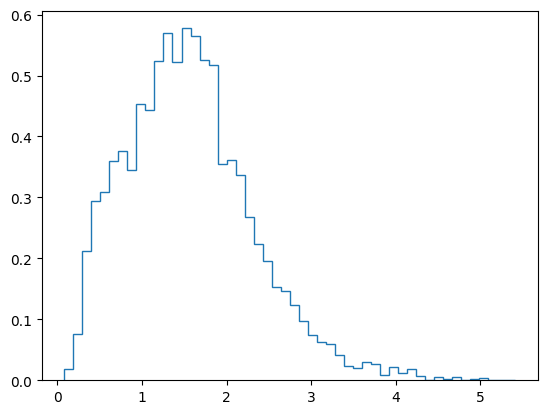

In [3]:
plt.hist(data,bins=50,histtype='step',density=True,label='original data');

A numpy histogram object out of the data with `density=True` and `bins=50` is a tuple of bin heights and bin edges.

In [4]:
np.histogram(data, bins=100,density=True)

(array([0.00750005, 0.03000019, 0.06750042, 0.08437555, 0.14812589,
        0.2756268 , 0.28312669, 0.30375182, 0.28875189, 0.33000216,
        0.38812754, 0.3318768 , 0.37500245, 0.37687747, 0.34875228,
        0.34125223, 0.41062723, 0.49687881, 0.46687753, 0.42000228,
        0.49687881, 0.54937798, 0.56812808, 0.57187938, 0.55500301,
        0.48937875, 0.53250289, 0.62250338, 0.55875428, 0.57000309,
        0.51937898, 0.53250289, 0.4968777 , 0.53625411, 0.39562715,
        0.31500241, 0.38062706, 0.34125185, 0.35437692, 0.31875173,
        0.29625293, 0.2400013 , 0.21375116, 0.23437627, 0.183751  ,
        0.20812706, 0.16125087, 0.14625079, 0.14062576, 0.15375083,
        0.14062639, 0.10500057, 0.10500057, 0.09000049, 0.07125039,
        0.07687576, 0.06750037, 0.05812532, 0.06375035, 0.05437529,
        0.04687546, 0.0375002 , 0.02250012, 0.02437513, 0.02437513,
        0.01687509, 0.03187532, 0.02812515, 0.03375018, 0.0187501 ,
        0.01500008, 0.00187502, 0.03187517, 0.01

### Cloning by rejection sampling

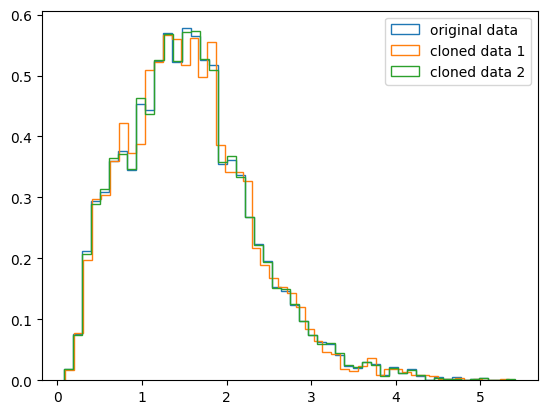

In [5]:
plt.hist(data,bins=50,histtype='step',density=True,label='original data');

# make a simple histogram object
counts, bins = np.histogram(data, bins=50, density=True)
maxh = counts.max() # find the maximum

# Make a scipy.stats random variable object from a histogram
# This is a great hack!
disth = scipy.stats.rv_histogram((counts,bins))

# Let's do it manually again
N = 100000 # trials
q = np.random.uniform(-10, 30, N) # proposed points
u = np.random.uniform(0, maxh, N) # uniform draws

mask = u<=disth.pdf(q) # assess whether u <= q(x_i)

monte_carlo = q[mask] # reject all points that don't pass, using masking

plt.hist(monte_carlo, bins=50, density=True,histtype='step',label='cloned data 1');

### But scipy has it already implemented 
plt.hist(disth.rvs(size=N),bins=50,density=True,histtype='step',label='cloned data 2');

plt.legend();

### Cloning by inverse transform

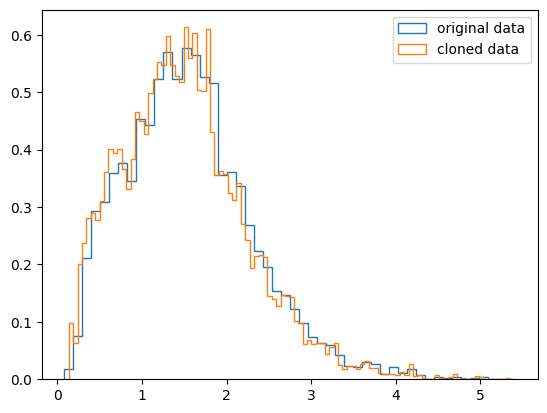

In [6]:
plt.hist(data,bins=50,histtype='step',density=True,label='original data');


# make a simple histogram object
counts, bins = np.histogram(data, bins=50, density=True)
bin_mids = (bins[1:] + bins[:-1]) / 2 # mid location of bins
 
simple_cdf = np.cumsum(counts) / np.sum(counts) # very simply cumulative sum

# set up an interpolation of the inverse cumulative distribution
tck = scipy.interpolate.interp1d(simple_cdf, bin_mids)

# sample evenly along the cumulative distribution, and interpolate
# little hack to make sure no points are generated outside interpolation range.
# not ideal
u = np.random.uniform(min(simple_cdf),max(simple_cdf), 10000) 
x_sample = tck(u)

plt.hist(x_sample, bins=100, density=True, histtype='step',label='cloned data');

plt.legend();

## Now some cosmology...

Let's try to assume that quasars are distributed uniformly in comoving volume in the Universe. Seems fair...

We use the cosmological parameters as measured by the Plack satellite, which is a flat $\Lambda$ CDM model



In [7]:
astropy.cosmology.Planck18

FlatLambdaCDM(name="Planck18", H0=67.66 km / (Mpc s), Om0=0.30966, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.04897)

Let's put things in a class now. Note **lazy loading**, which is a terrific tecnique!

In [8]:
class uniformredshift(object):
    def __init__(self,zmax):
        ''' Lazy loading...'''
        self._norm = None
        self._pdfmax = None
        self.zmax=zmax

    def _eval(self,z_vals):
        '''Unnormalized pdf'''
        return ((4.*np.pi*astropy.cosmology.Planck18.differential_comoving_volume(z_vals).value))


    def norm(self):
        '''Compute normalization'''
        if self._norm is None:
            self._norm = scipy.integrate.quad( self._eval, 0, self.zmax)[0]
        return self._norm


    def eval(self,z_vals):
        return self._eval(z_vals)/self.norm()

        return np.array(zsample)

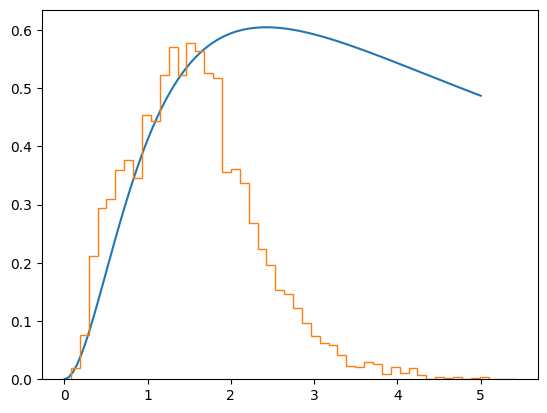

In [9]:
redshiftpdf = uniformredshift(zmax = 5)

z = np.linspace(0,5,100)
plt.plot(z,2.4*redshiftpdf.eval(z)) ###   Arbitrary normalization, just matching by eye

plt.hist(data,bins=50,histtype='step',density=True,label='original data');


They are not distributed unifiormly in comoving volume! I mean, they are but only at low redshits.

Surely are all quasars created equally? But do we see them equally?